In [1]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
image_path = 'images_tcc15/'
image_test_path = 'images_test_tcc15/'
annotation_path = 'annotations_tcc15/'
annotation_test_path = 'annotations_test_tcc15/'

In [4]:
print('images/', len(os.listdir(image_path)))
print('annotations/', len(os.listdir(annotation_path)))
print('test_annotations/', len(os.listdir(image_test_path)))
print('test_images/', len(os.listdir(annotation_test_path)))

images/ 1287
annotations/ 1287
test_annotations/ 321
test_images/ 321


In [5]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

classes = {
    1: "Transverse Crack",
    2: "Longitudinal Crack",
    3: "Block Crack",
    4: "Alligator Crack",
    5: "Edge Cracks",
    6: "Potholes",
    7: "Rutting",
    8: "Raveling",
    9: "Depression",
    10: "Corrugation and shoving",
    11: "Patching",
    12: "Manhole",
    13: "Slippage Cracking"
}


def generate_label(obj):
    if obj.find('name').text == "Transverse Crack":          return 1
    elif obj.find('name').text == "Longitudinal Crack":      return 2
    elif obj.find('name').text == "Block Crack":             return 3
    elif obj.find('name').text == "Alligator Crack":         return 4
    elif obj.find('name').text == "Edge Cracks":             return 5
    elif obj.find('name').text == "Potholes":                return 6
    elif obj.find('name').text == "Rutting":                 return 7
    elif obj.find('name').text == "Raveling":                return 8
    elif obj.find('name').text == "Depression":              return 9
    elif obj.find('name').text == "Corrugation and shoving": return 10
    elif obj.find('name').text == "Patching":                return 11
    elif obj.find('name').text == "Manhole":                 return 12
    elif obj.find('name').text == "Slippage Cracking":       return 13

    
def plot_image_from_output(img, annotation):
    # Convert the image tensor to a format suitable for plotting
    img = img.cpu().permute(1, 2, 0)
    
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(20, 20))
    ax.imshow(img)
    
    # Define a dictionary to map labels to edge colors
    label_to_color = {
        1: '#ff007c',
        2: '#018477',
        3: '#b4a808',
        4: '#ddff33',
        5: '#ff00cc',
        6: '#fa3253',
        7: '#24b353',
        8: '#bac99a',
        9: '#d3a298',
        10: '#505016',
        11: '#75c50d'
    }
    
    # Loop through the annotations and draw rectangles and labels
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        label = int(annotation['labels'][idx])
        edgecolor = label_to_color.get(label, 'r')  # Default to 'r' if label not in dictionary

        # Create and add the rectangle
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor=edgecolor, facecolor='none')
        ax.add_patch(rect)
        
        # Add the label text inside the rectangle
        text_x = xmin
        text_y = ymin
        label_text = classes.get(label, 'Unknown') 
        label_text = label_text + " - " + str(label)
        ax.text(text_x, text_y, label_text, color='white', fontsize=8, ha='center', va='center', bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, boxstyle='round,pad=0.2'))
    
    # Display the plot
    plt.show()
    
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

In [6]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        #print('reading image', file_image)
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join(annotation_test_path, file_label)
        else:
            label_path = os.path.join(annotation_path, file_label)

        
        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor(),
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, image_path)
test_dataset = MaskDataset(data_transform, image_test_path)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [7]:
def getModel(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
model = getModel(14)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [9]:
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

num_epochs = 20
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Optimization 1
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
print('----------------------train start--------------------------')

loss_list = []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    loss_list.append(epoch_loss)
    scheduler.step()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

print('----------------------train end--------------------------')

----------------------train start--------------------------
epoch : 1, Loss : 263.9668884277344, time : 408.03114342689514
epoch : 2, Loss : 241.8832550048828, time : 419.86388301849365
epoch : 3, Loss : 224.5760955810547, time : 419.4309241771698
epoch : 4, Loss : 202.490234375, time : 419.56310200691223
epoch : 5, Loss : 183.1730194091797, time : 419.4867091178894
epoch : 6, Loss : 159.65406799316406, time : 419.2537021636963
epoch : 7, Loss : 139.7831268310547, time : 420.2426915168762
epoch : 8, Loss : 130.6587371826172, time : 420.01204347610474
epoch : 9, Loss : 97.88312530517578, time : 420.61454582214355
epoch : 10, Loss : 77.60264587402344, time : 420.80890560150146
epoch : 11, Loss : 62.52642822265625, time : 420.89995527267456
epoch : 12, Loss : 51.14055252075195, time : 421.64318203926086
epoch : 13, Loss : 44.199466705322266, time : 420.544549703598
epoch : 15, Loss : 40.0677490234375, time : 420.81134128570557
epoch : 16, Loss : 36.2850227355957, time : 419.91349697113037

In [ ]:
torch.save(model.state_dict(),f'model_train4_{num_epochs}.pt')

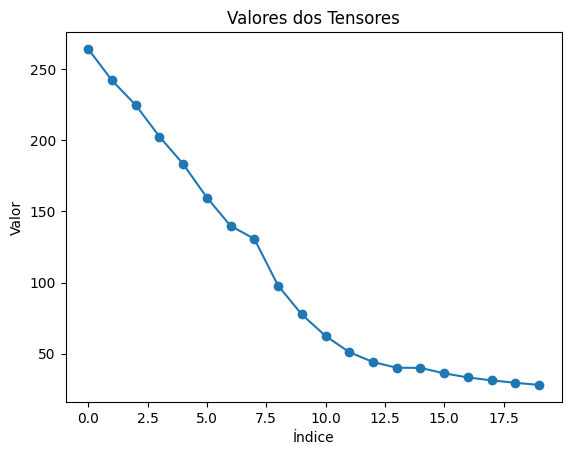

In [ ]:
valores = [t.item() for t in loss_list]

# Plotar o gráfico
plt.plot(valores, marker='o')
plt.title('Valores dos Tensores')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.show()

In [10]:
model.load_state_dict(torch.load(f'model_train4_{num_epochs}.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)

    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [12]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 161/161 [01:26<00:00,  1.87it/s]


In [ ]:
'''
    1: "Transverse Crack",
    2: "Longitudinal Crack",
    3: "Block Crack",
    4: "Alligator Crack",
    5: "Edge Cracks",
    6: "Potholes",
        7: "Rutting",
    8: "Raveling",
        9: "Depression",
    10: "Corrugation and shoving",
    11: "Patching",
    12: "Manhole",
        13: "Slippage Cracking"
'''

'\n    1: "Transverse Crack",\n    2: "Longitudinal Crack",\n    3: "Block Crack",\n    4: "Alligator Crack",\n    5: "Edge Cracks",\n    6: "Potholes",\n        7: "Rutting",\n    8: "Raveling",\n        9: "Depression",\n    10: "Corrugation and shoving",\n    11: "Patching",\n    12: "Manhole",\n        13: "Slippage Cracking"\n'

In [13]:
from utils import functions

In [14]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += functions.getStatistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = functions.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.10348991432302412
AP : tensor([0.0647, 0.0272, 0.0000, 0.1206, 0.0093, 0.0000, 0.0336, 0.0000, 0.0294,
        0.7500], dtype=torch.float64)


In [15]:
# Function to remove scores from a tensor dictionary
def remove_scores(tensor_dict):
    # Create a new dictionary without the 'scores' key
    new_dict = {key: value for key, value in tensor_dict.items() if key != 'scores'}
    return new_dict

def remove_device(tensor_dict):
    new_dict = {}
    for key, value in tensor_dict.items():
        # Move the tensor to CPU memory
        new_dict[key] = value.to('cpu')
    return new_dict

def remove_cuda(tensor_dict):
    new_dict = {}
    for key, value in tensor_dict.items():
        # Move the tensor to CPU memory
        new_dict[key] = value.to('cpu').detach().numpy()
    return new_dict

In [16]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += functions.getStatistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.2) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = functions.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.15151481856211774
AP : tensor([0.1103, 0.0837, 0.0000, 0.3784, 0.0120, 0.0000, 0.0896, 0.0000, 0.0911,
        0.7500], dtype=torch.float64)


In [17]:
# Extract labels
all_labels = set()
for sublist in annot_all:
    for dictionary in sublist:
        labels = dictionary['labels']
        all_labels.update(labels.tolist())

print("All labels:", all_labels)

All labels: {1, 2, 3, 4, 5, 6, 8, 10, 11, 12}


In [18]:
# Extract scores tensors and calculate the average
total_scores = []
for sublist in preds_adj_all:
    for dictionary in sublist:
        total_scores.append(dictionary['scores'])

all_scores = torch.cat(total_scores)
average_score = torch.mean(all_scores)

print("Average score:", average_score.item())

Average score: 0.8229743838310242


In [19]:
import pandas as pd

# Dados fornecidos

class_names = ['Transverse Crack', 'Longitudinal Crack', 'Block Crack', 'Alligator Crack', 'Edge Cracks', 'Potholes', 'Raveling', 'Corrugation and shoving', 'Patching', 'Manhole']

# Criação do DataFrame 50% IOU
data = {
    'Label': class_names,
    'Precision': precision.numpy(),
    'Recall': recall.numpy(),
    'F1 Score': f1.numpy(),
    'AP': AP.numpy()    
}

df = pd.DataFrame(data)

# Exibir o DataFrame
print(df)

                     Label  Precision    Recall  F1 Score        AP
0         Transverse Crack   0.157895  0.250000  0.193548  0.110302
1       Longitudinal Crack   0.336449  0.206897  0.256228  0.083666
2              Block Crack   0.000000  0.000000  0.000000  0.000000
3          Alligator Crack   0.514793  0.539256  0.526741  0.378393
4              Edge Cracks   0.090909  0.055556  0.068966  0.012037
5                 Potholes   0.000000  0.000000  0.000000  0.000000
6                 Raveling   0.294118  0.212355  0.246637  0.089618
7  Corrugation and shoving   0.000000  0.000000  0.000000  0.000000
8                 Patching   0.325301  0.164634  0.218623  0.091132
9                  Manhole   1.000000  0.750000  0.857143  0.750000


In [20]:
# Salvar o DataFrame no formato CSV
csv_file_path = 'output-train4.csv'
df.to_csv(csv_file_path, index=False)

print(f"DataFrame salvo como {csv_file_path}")

DataFrame salvo como output-train4.csv


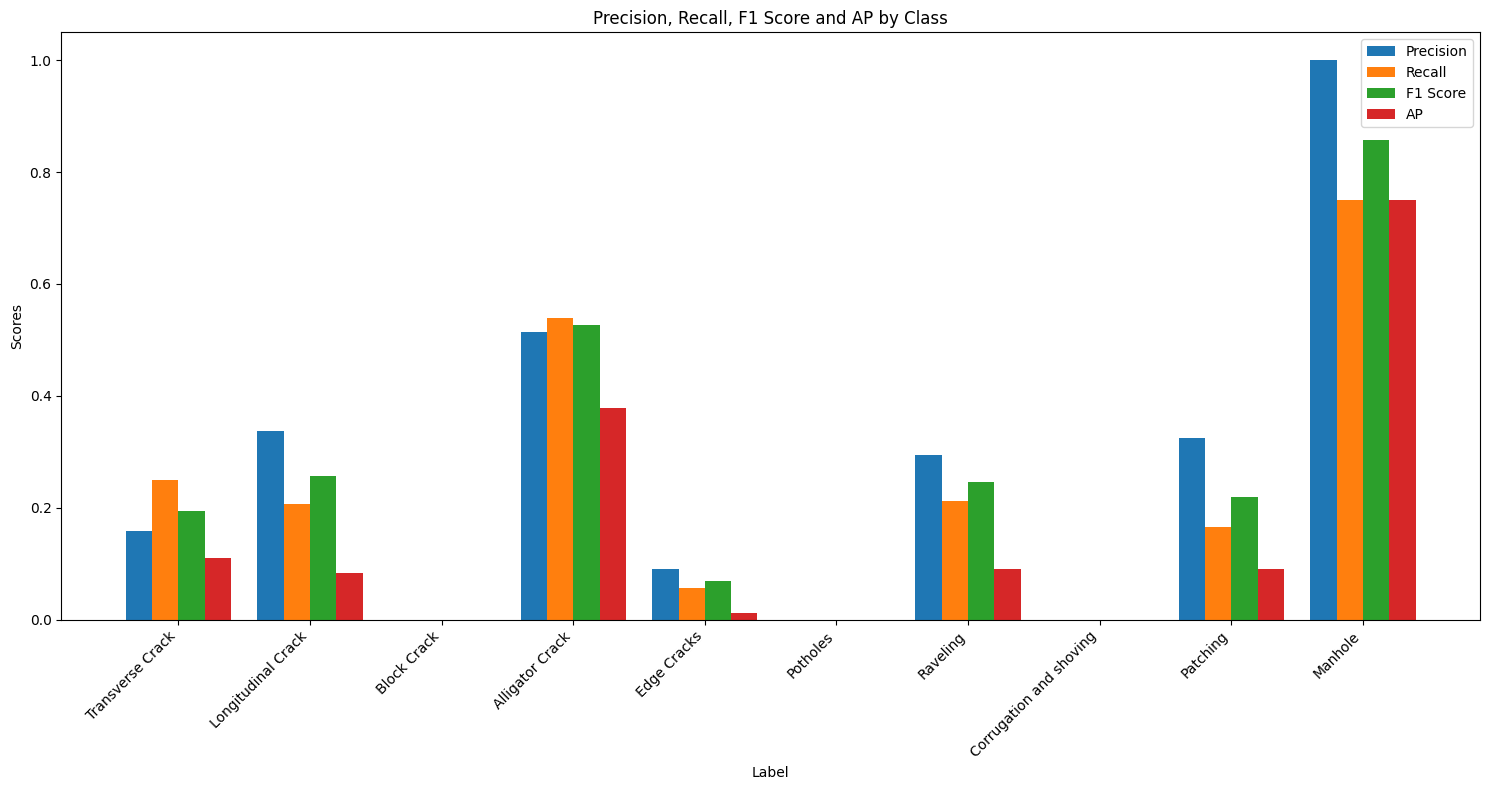

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Gráfico de barras
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = df.index

bar1 = plt.bar(index, df['Precision'], bar_width, label='Precision')
bar2 = plt.bar(index + bar_width, df['Recall'], bar_width, label='Recall')
bar3 = plt.bar(index + 2 * bar_width, df['F1 Score'], bar_width, label='F1 Score')
bar4 = plt.bar(index + 3 * bar_width, df['AP'], bar_width, label='AP')

plt.xlabel('Label')
plt.ylabel('Scores')
plt.title('Precision, Recall, F1 Score and AP by Class')
plt.xticks(index + 1.5 * bar_width, df['Label'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


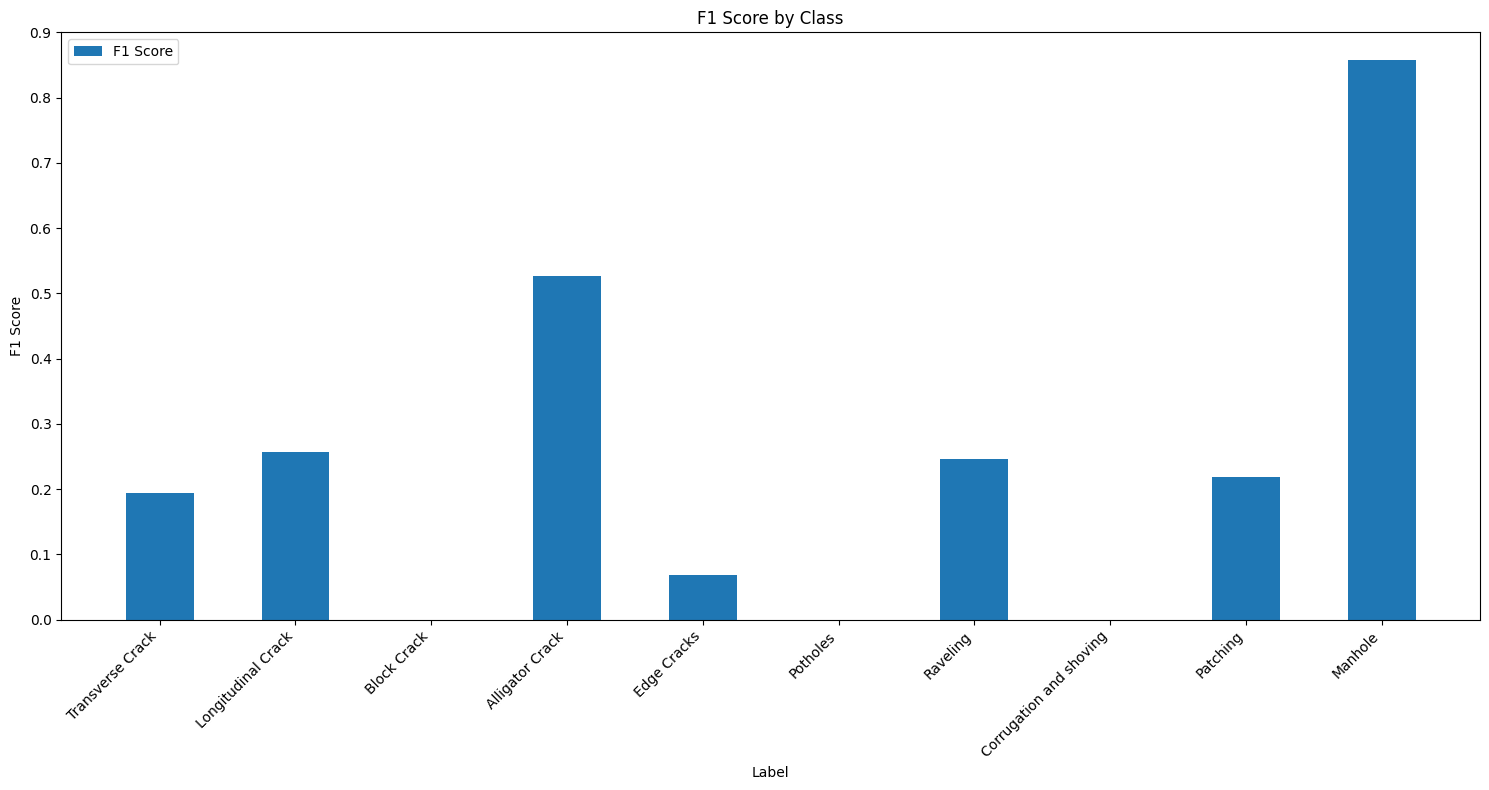

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.5
index = df.index

plt.bar(index, df['F1 Score'], bar_width, label='F1 Score')

plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.title('F1 Score by Class')
plt.xticks(index, df['Label'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()